In [1]:

import os
import cv2
import json
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.utils import plot_model

In [2]:
const = 27
np.random.seed(const)
random.seed(const)
tf.random.set_seed(const)

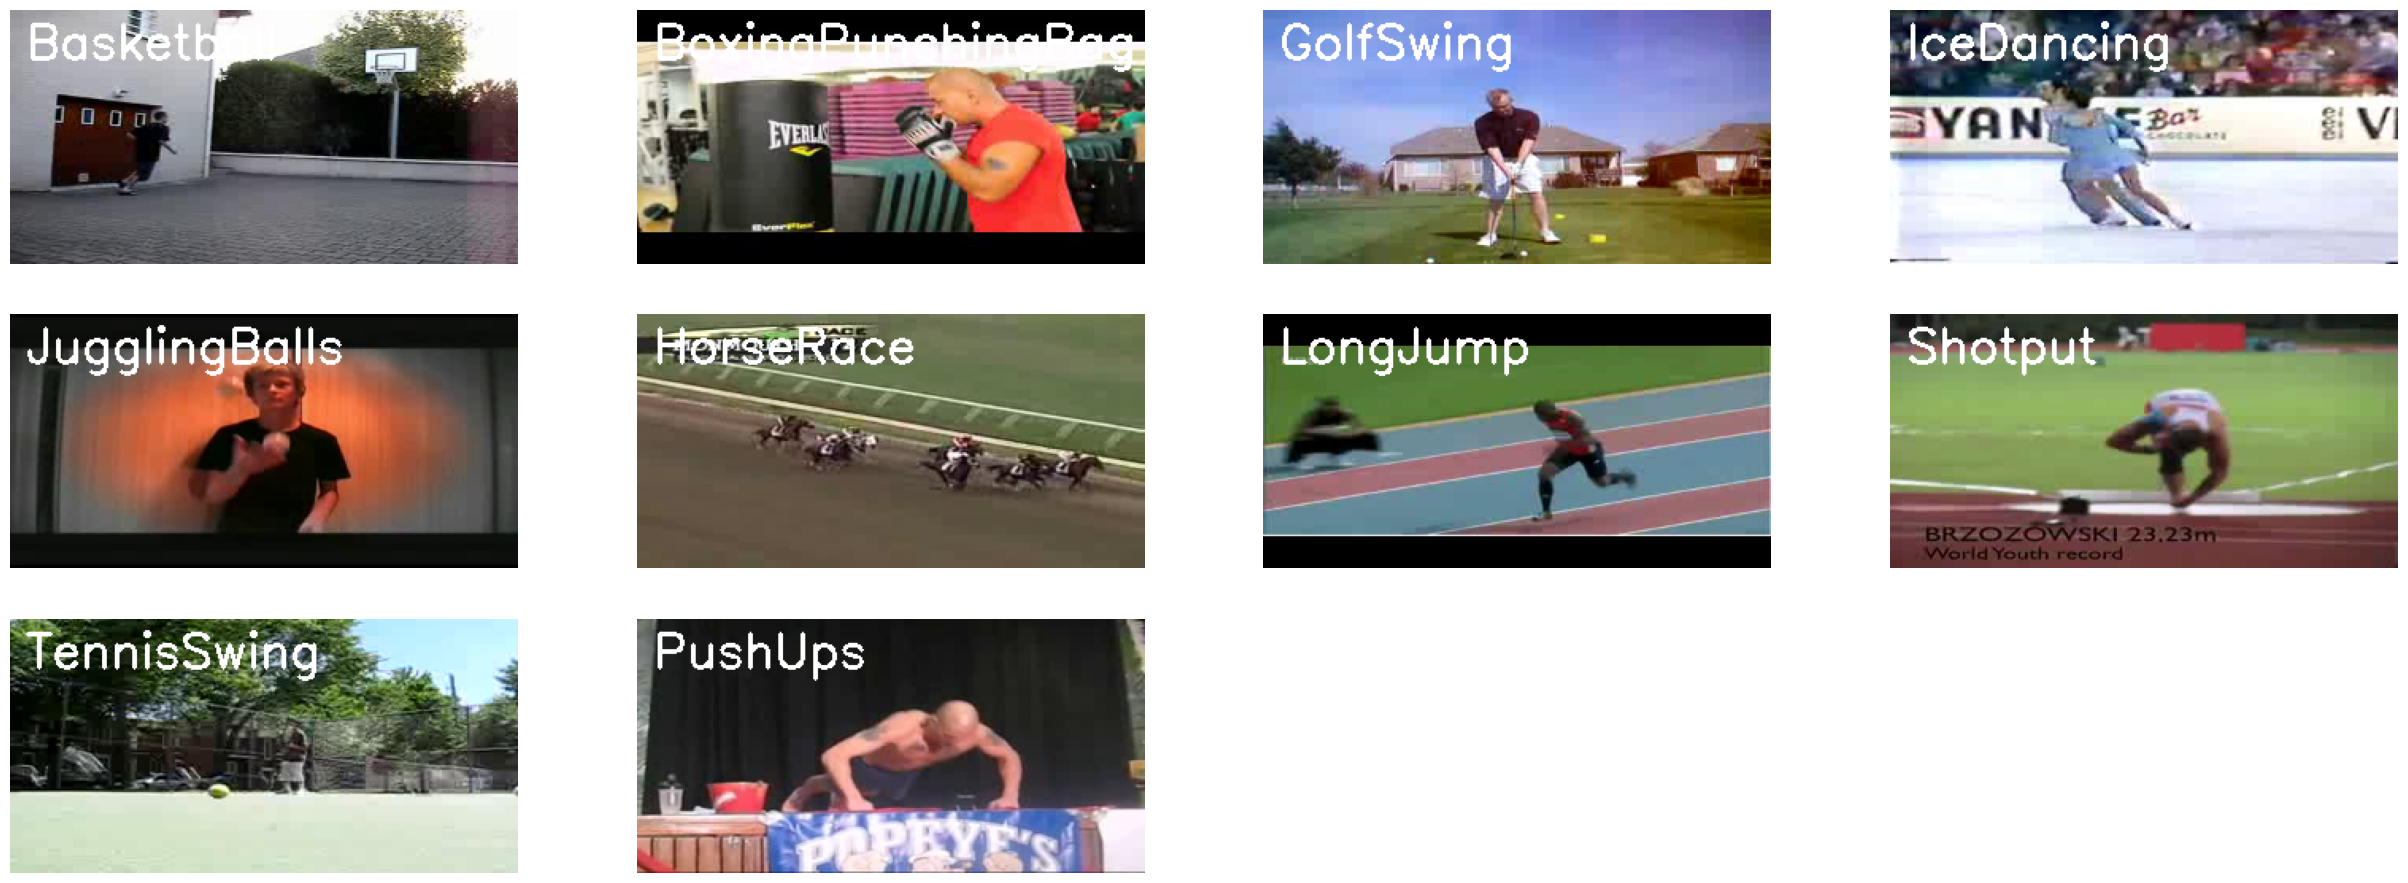

In [3]:

video_directory =  r"C:\Users\VISHAL KHUMAR P D\Downloads\HacktheBox Challenge\UCF101 for hackthebox"

all_classes_names =[
                    "Basketball", "BoxingPunchingBag", "GolfSwing", "IceDancing", "JugglingBalls",
                    "HorseRace", "LongJump", "Shotput", "TennisSwing", "PushUps"
               ]
IMAGE_HEIGHT, IMAGE_WIDTH = 160, 320
plt.figure(figsize=(31, 31))

for counter, class_name in enumerate(all_classes_names, 1):
    
    video_files = os.listdir(os.path.join(video_directory, class_name))
    selected_video_file = random.choice(video_files)
    video_path = os.path.join(video_directory, class_name, selected_video_file)
    video_capture = cv2.VideoCapture(video_path)
    _, frame = video_capture.read()
    video_capture.release()
    

    resized_frame = cv2.resize(frame, (IMAGE_WIDTH, IMAGE_HEIGHT))
    rgb_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)
    cv2.putText(rgb_frame, class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    plt.subplot(8, 4, counter)
    plt.imshow(rgb_frame)
    plt.axis('off')
plt.show()

In [4]:

IMAGE_HEIGHT , IMAGE_WIDTH = 100,100
SEQUENCE_LENGTH = 20
DATASET_DIR = r"C:\Users\VISHAL KHUMAR P D\Downloads\HacktheBox Challenge\UCF101 for hackthebox"
CLASSES_LIST = [
                    "Basketball", "BoxingPunchingBag", "GolfSwing", "IceDancing", "JugglingBalls",
                    "HorseRace", "LongJump", "Shotput", "TennisSwing", "PushUps"
               ]



In [5]:
def frames_extraction(video_path):
 
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):


        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
   
    video_reader.release()

    return frames_list

In [6]:
def create_dataset():


    features = []
    labels = []
    video_files_paths = []

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            
           
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [7]:

features, labels, video_files_paths = create_dataset()

Extracting Data of Class: Basketball
Extracting Data of Class: BoxingPunchingBag
Extracting Data of Class: GolfSwing
Extracting Data of Class: IceDancing
Extracting Data of Class: JugglingBalls
Extracting Data of Class: HorseRace
Extracting Data of Class: LongJump
Extracting Data of Class: Shotput
Extracting Data of Class: TennisSwing
Extracting Data of Class: PushUps


In [8]:

print(features)
print(labels)
one_hot_encoded_labels = to_categorical(labels)

[[[[[0.03137255 0.03137255 0.03137255]
    [0.05882353 0.05882353 0.05882353]
    [0.08627451 0.08627451 0.08627451]
    ...
    [0.0627451  0.02745098 0.05098039]
    [0.04705882 0.05882353 0.07843137]
    [0.07058824 0.0745098  0.09411765]]

   [[0.01960784 0.01960784 0.01960784]
    [0.04313725 0.04313725 0.04313725]
    [0.0745098  0.0745098  0.0745098 ]
    ...
    [0.14509804 0.10588235 0.12941176]
    [0.10588235 0.10588235 0.1254902 ]
    [0.04705882 0.02352941 0.04313725]]

   [[0.04313725 0.04313725 0.04313725]
    [0.06666667 0.06666667 0.06666667]
    [0.08627451 0.08627451 0.08627451]
    ...
    [0.10588235 0.08627451 0.10980392]
    [0.01176471 0.00784314 0.02745098]
    [0.05490196 0.02352941 0.05098039]]

   ...

   [[0.60392157 0.59607843 0.50196078]
    [0.60392157 0.59607843 0.50196078]
    [0.61568627 0.60784314 0.51372549]
    ...
    [0.56470588 0.57647059 0.48627451]
    [0.5372549  0.54901961 0.45882353]
    [0.50980392 0.52156863 0.43137255]]

   [[0.60392157 

In [9]:

print(features.shape)
print(labels.shape)
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.05, shuffle = True, random_state = const)

(1382, 20, 100, 100, 3)
(1382,)


In [10]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
   
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)


    plt.title(str(plot_name))

    plt.legend()

In [11]:
def create_LRCN_model():
    model = Sequential()
   
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same',activation = 'relu'),
                              input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4)))) 
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [12]:

LRCN_model = create_LRCN_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 25, 25, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 25, 25, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 25, 25, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 6, 6, 32)     0

In [13]:

plot_model(LRCN_model, to_file = 'LRCN_model_structure_plot.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [14]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)
LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
print(features_test.shape)
print(features_train.shape)
print(features.shape)
print(labels.shape)
print(labels_train.shape)
print(labels_test.shape)
# Start training the model.
LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback])

(70, 20, 100, 100, 3)
(1312, 20, 100, 100, 3)
(1382, 20, 100, 100, 3)
(1382,)
(1312, 10)
(70, 10)
Epoch 1/70
263/263 [==============================] - 82s 284ms/step - loss: 2.1844 - accuracy: 0.1773 - val_loss: 2.0823 - val_accuracy: 0.2281
Epoch 2/70
263/263 [==============================] - 62s 237ms/step - loss: 1.8145 - accuracy: 0.3804 - val_loss: 1.8322 - val_accuracy: 0.3460
Epoch 3/70
263/263 [==============================] - 65s 246ms/step - loss: 1.4944 - accuracy: 0.4786 - val_loss: 1.4480 - val_accuracy: 0.4335
Epoch 4/70
263/263 [==============================] - 74s 281ms/step - loss: 1.1641 - accuracy: 0.5910 - val_loss: 1.1341 - val_accuracy: 0.5856
Epoch 5/70
263/263 [==============================] - 67s 253ms/step - loss: 0.9266 - accuracy: 0.6635 - val_loss: 1.1290 - val_accuracy: 0.5856
Epoch 6/70
263/263 [==============================] - 66s 251ms/step - loss: 0.8598 - accuracy: 0.6940 - val_loss: 0.8582 - val_accuracy: 0.7148
Epoch 7/70
263/263 [============

In [15]:
# Evaluate the trained model.
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

3/3 [==============================] - 1s 264ms/step - loss: 0.2374 - accuracy: 0.9714


In [16]:

model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'
LRCN_model.save(model_file_name)

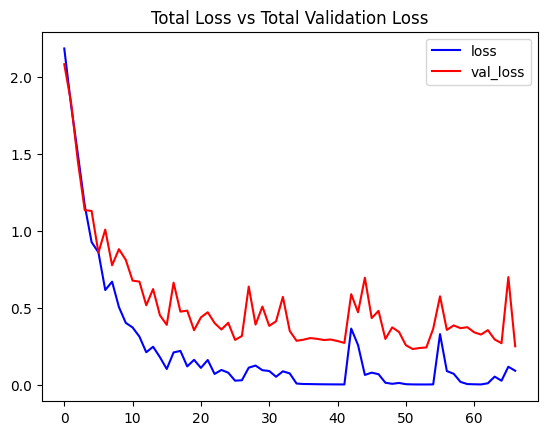

In [17]:

plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

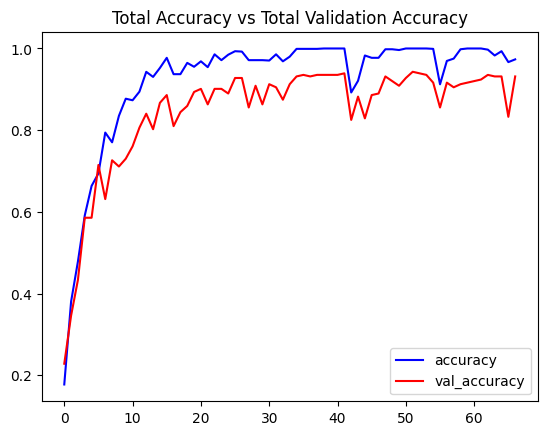

In [18]:

plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')